# Figure 1 Final

Notebook to make figure 1 for ms <br>
by Cascade Tuholske 2020.02.23

In [3]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [9]:
#### Load Data

# file paths
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"
FN_IN = ""
FN_IN = '/home/cascade/projects/UrbanHeat/data/processed/oldworkflow/All_data_Raw406_es_final_pdayadd.csv'

df_data = pd.read_csv(FN_IN)

In [10]:
# Check it
df_data.head()

,Unnamed: 0,ID_HDC_G0,year,total_days,CTR_MN_NM,sub-region,region,intermediate-region,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,0,2784,1983,1,Germany,Western Europe,Europe,Western Europe,9.976361e+05,997636.118717,1.573652e+06,0.000998,0.000998,0.000000e+00
1,1,2784,2013,1,Germany,Western Europe,Europe,Western Europe,1.538112e+06,997636.118717,1.573652e+06,0.001538,0.000998,5.404756e-04
2,2,2833,1983,1,Germany,Western Europe,Europe,Western Europe,6.014093e+04,60140.932532,6.497856e+04,0.000060,0.000060,0.000000e+00
3,3,2833,1984,1,Germany,Western Europe,Europe,Western Europe,6.033127e+04,60140.932532,6.497856e+04,0.000060,0.000060,1.903325e-07
4,4,2833,1998,1,Germany,Western Europe,Europe,Western Europe,6.411484e+04,60140.932532,6.497856e+04,0.000064,0.000060,3.973904e-06


In [11]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col, scale):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1]*scale)
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

Text(2.46, 0.8, '140m increase in people-\ndays per year ($R^2$=0.32)*')

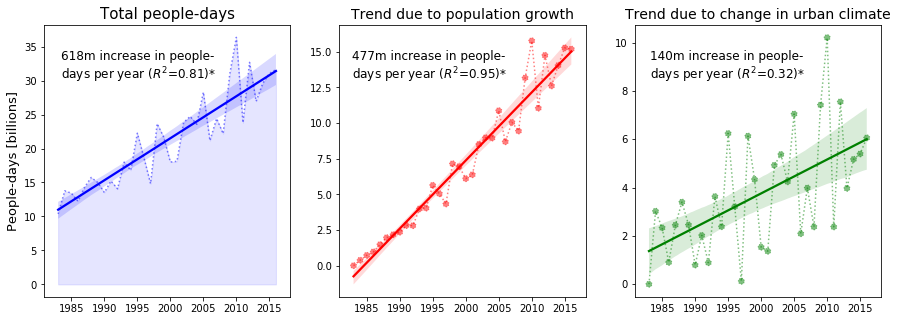

In [20]:
#### Make Figure & Save it

fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharex=True)

## PLOT 1 - People Days
color = 'blue'
data = df_data.groupby('year')['people_days'].sum() 
years = list(data.index)
axs[0].plot(data, color = color, linestyle = ':', alpha = 0.5)
axs[0].fill_between(years, data, color = color, alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = color, ax = axs[0], scatter = False, truncate = True)
axs[0].set_title('Total people-days', size = 15 )
axs[0].set_ylabel('People-days [billions]', fontsize = 13)

# Add text
coef, r2, p = lm_func(df_data, 'people_days', 10**3)
text = str(coef)+'m increase in people-\ndays per year ($R^2$=' + str(r2) + ')*'
axs[0].text(0.07, .8, text, transform=axs[0].transAxes, size=12)

#2 PLOT 2 - People Days delta pop x days
color = 'red'
data = df_data.groupby('year')['people_days_pop'].sum() 
axs[1].scatter(years, data, color = color, linestyle = ':', alpha = 0.5)
axs[1].plot(data, color = color, linestyle = ':', alpha = 0.5)
sns.regplot(years, data, color = color, ax = axs[1], scatter = False, truncate = True)
axs[1].set_title('Trend due to population growth', size = 14)
axs[1].set_ylabel('')

# Add text
coef, r2, p = lm_func(df_data, 'people_days_pop', 10**3)
text = str(coef)+'m increase in people-\ndays per year ($R^2$=' + str(r2) + ')*'
axs[1].text(1.25, .8, text, transform=axs[0].transAxes, size=12)

## PLOT 3 - People Days due to heat
color = 'green'
data = df_data.groupby('year')['people_days_heat'].sum()
pdays83 = data.get(data.index[0])
data = data - pdays83
years = list(data.index)
axs[2].scatter(years, data, color = color, linestyle = ':', alpha = 0.5)
axs[2].plot(data, color = color, linestyle = ':', alpha = 0.5)
sns.regplot(years, data, color = color, ax = axs[2], scatter = False, truncate = True)
axs[2].set_title('Trend due to change in urban climate', size = 14)
axs[2].set_ylabel('')

# Add text
coef, r2, p = lm_func(df_data, 'people_days_heat', 10**3)
text = str(coef)+'m increase in people-\ndays per year ($R^2$=' + str(r2) + ')*'
axs[2].text(1.25*2-0.04, .8, text, transform=axs[0].transAxes, size=12,)

# Set y-axis
# for ax in fig.get_axes():
#     ax.label_outer()

#plt.savefig(FIG_OUT+'FIG1.png')

